### Boosting for classifying individuals

In [1]:
library(tidyverse)
install.packages("gbm")
library(gbm)
library(caret)
library(pROC)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ───────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loaded gbm 2.1.8
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



### Real data

In [3]:
data <- readRDS(snakemake@input[["input_predictions"]])
#data <- data[1:3000, 1:50]
head(data)

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_434,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442
V1,PGDX16568P,0.7384158,-0.8056722,0.6390487,-0.8985149,-0.4953916,-0.3241811,0.1041488,0.8329909,0.7424178,...,-0.7262818,-0.3564953,-1.1294548,-0.8340362,-1.0569895,-0.5906257,-0.4070908,0.748539037,-0.8092159,-0.8740796
V2,PGDX16569P,0.6625254,-0.8741453,0.7765665,-1.1988164,-0.8354591,-0.4988171,-0.3283077,0.7640395,0.6334283,...,-0.6978321,-0.4530649,-0.3910418,-0.9204722,-0.9963903,-0.9371117,-1.2525610,0.006981209,-0.7108791,-1.0691730
V3,PGDX16570P,0.3857611,-0.9628727,0.8915373,-0.9955061,-0.4230742,-0.7763890,-0.3731460,1.0335064,0.6371296,...,-0.6822172,-1.3988347,-0.9590603,-0.5400694,-0.7874469,-0.5155926,-0.5203073,0.973058324,-0.7016159,-0.8953489
V4,PGDX16571P,0.7517641,-1.0829291,0.7057104,-0.7732682,-0.4899441,-0.4288467,-0.3100476,0.7132819,0.3474689,...,-0.8839149,-1.2089010,-0.9277275,-1.0276412,-1.0220272,-0.9369146,-1.4590158,0.805892569,-0.8962095,-1.1176343
V5,PGDX16579P,0.6788690,-1.0408928,0.8311217,-0.9623741,-1.2931478,-0.5956232,-0.2359559,0.3395272,0.2934176,...,-0.9314722,-1.2097858,-0.9382521,-0.6274437,-1.0620425,-0.8472646,-1.1438953,0.508068643,-0.8234048,-1.2768384
V6,PGDX16580P,0.6295501,-0.8169236,0.7086020,-1.1560383,-0.7778377,-0.7474290,-0.2509807,0.8273938,0.3555049,...,-0.7093650,-0.5272784,-1.2087402,-0.2983708,-1.0748863,-1.0424165,-0.9461238,0.689832773,-0.9728878,-1.3499044


In [4]:
#input_sample_type <- as.character(snakemake@input[["input_sample_type"]])
sample_types <- readRDS(file = snakemake@input[["input_sample_types"]])
colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [5]:
dim(data)
dim(sample_types)

[1] 3000   50

[1] 473   2

In [6]:
data <- merge(data, sample_types, by="sample")
head(data)

data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)
                        

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type
PGDX10344P1,0.34490540,-0.8000112,1.1127233,-0.72348445,-0.1344115,-0.7265351,0.085121036,0.3619022,0.2068427,...,-1.1441469,-0.5879391,0.1086215,-0.9976533,-1.4026843,-0.73360822,0.1324393,-0.9783173,-1.0005036,Gastric_cancer
PGDX10346P1,1.28633538,-0.7918092,0.9359498,-0.62758859,-0.8147757,-0.5206750,-0.003911045,0.7023168,0.4172394,...,-0.7814404,-1.2770596,-0.1570362,-1.2541964,-0.3779781,-0.08929468,0.5743405,-0.8899582,-1.0335331,Gastric_cancer
PGDX10349P1,0.07358182,-1.0182200,0.3571508,-1.10485839,-0.7703527,-0.9071947,-0.037952891,0.4907300,2.2597325,...,-0.6928324,-1.3631100,-0.7634719,-1.0129522,-1.1056200,-1.19634756,-0.8850462,-0.6721729,-0.8582949,Gastric_cancer
PGDX10351P1,1.35764667,-1.4175205,0.5032006,-1.20173705,-0.6208763,-0.2471645,-0.407286969,0.9077979,0.6310652,...,-0.8844944,-1.1465975,-0.3398387,-0.2474790,-1.2346054,0.03094330,0.9890714,-0.4544031,-1.1479774,Gastric_cancer
PGDX10566P,0.37564894,-1.0425695,1.0316814,-0.91694916,-0.3979850,-0.8132378,-0.185403607,0.7225772,0.6183614,...,-0.8562104,-0.8011278,-0.2355608,-0.9995219,-0.9572128,-1.40899667,0.3462910,-1.4520073,-0.6590769,Ovarian_Cancer
PGDX10567P,1.11594208,-0.7729504,1.0216299,-0.09896146,-0.6291048,-0.8533494,0.169204614,0.6894213,0.7569859,...,-1.2548302,-0.6579014,-0.8200128,-0.7894627,-1.3894036,-1.11591365,0.9555086,-0.4129623,-0.1692571,Ovarian_Cancer


sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type,sample_type01
PGDX10344P1,0.34490540,-0.8000112,1.1127233,-0.72348445,-0.1344115,-0.7265351,0.085121036,0.3619022,0.2068427,...,-0.5879391,0.1086215,-0.9976533,-1.4026843,-0.73360822,0.1324393,-0.9783173,-1.0005036,Gastric_cancer,1
PGDX10346P1,1.28633538,-0.7918092,0.9359498,-0.62758859,-0.8147757,-0.5206750,-0.003911045,0.7023168,0.4172394,...,-1.2770596,-0.1570362,-1.2541964,-0.3779781,-0.08929468,0.5743405,-0.8899582,-1.0335331,Gastric_cancer,1
PGDX10349P1,0.07358182,-1.0182200,0.3571508,-1.10485839,-0.7703527,-0.9071947,-0.037952891,0.4907300,2.2597325,...,-1.3631100,-0.7634719,-1.0129522,-1.1056200,-1.19634756,-0.8850462,-0.6721729,-0.8582949,Gastric_cancer,1
PGDX10351P1,1.35764667,-1.4175205,0.5032006,-1.20173705,-0.6208763,-0.2471645,-0.407286969,0.9077979,0.6310652,...,-1.1465975,-0.3398387,-0.2474790,-1.2346054,0.03094330,0.9890714,-0.4544031,-1.1479774,Gastric_cancer,1
PGDX10566P,0.37564894,-1.0425695,1.0316814,-0.91694916,-0.3979850,-0.8132378,-0.185403607,0.7225772,0.6183614,...,-0.8011278,-0.2355608,-0.9995219,-0.9572128,-1.40899667,0.3462910,-1.4520073,-0.6590769,Ovarian_Cancer,1
PGDX10567P,1.11594208,-0.7729504,1.0216299,-0.09896146,-0.6291048,-0.8533494,0.169204614,0.6894213,0.7569859,...,-0.6579014,-0.8200128,-0.7894627,-1.3894036,-1.11591365,0.9555086,-0.4129623,-0.1692571,Ovarian_Cancer,1


In [7]:
#data %>% filter(sample_type == "Healthy")

data <- data %>% select(-sample_type)

In [8]:
data <- data %>% select(-sample)
head(data)

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type01
0.34490540,-0.8000112,1.1127233,-0.72348445,-0.1344115,-0.7265351,0.085121036,0.3619022,0.2068427,1.51435796,...,-1.1441469,-0.5879391,0.1086215,-0.9976533,-1.4026843,-0.73360822,0.1324393,-0.9783173,-1.0005036,1
1.28633538,-0.7918092,0.9359498,-0.62758859,-0.8147757,-0.5206750,-0.003911045,0.7023168,0.4172394,0.04422949,...,-0.7814404,-1.2770596,-0.1570362,-1.2541964,-0.3779781,-0.08929468,0.5743405,-0.8899582,-1.0335331,1
0.07358182,-1.0182200,0.3571508,-1.10485839,-0.7703527,-0.9071947,-0.037952891,0.4907300,2.2597325,1.27638664,...,-0.6928324,-1.3631100,-0.7634719,-1.0129522,-1.1056200,-1.19634756,-0.8850462,-0.6721729,-0.8582949,1
1.35764667,-1.4175205,0.5032006,-1.20173705,-0.6208763,-0.2471645,-0.407286969,0.9077979,0.6310652,0.86066992,...,-0.8844944,-1.1465975,-0.3398387,-0.2474790,-1.2346054,0.03094330,0.9890714,-0.4544031,-1.1479774,1
0.37564894,-1.0425695,1.0316814,-0.91694916,-0.3979850,-0.8132378,-0.185403607,0.7225772,0.6183614,0.80879438,...,-0.8562104,-0.8011278,-0.2355608,-0.9995219,-0.9572128,-1.40899667,0.3462910,-1.4520073,-0.6590769,1
1.11594208,-0.7729504,1.0216299,-0.09896146,-0.6291048,-0.8533494,0.169204614,0.6894213,0.7569859,0.53877625,...,-1.2548302,-0.6579014,-0.8200128,-0.7894627,-1.3894036,-1.11591365,0.9555086,-0.4129623,-0.1692571,1


In [12]:
data$sample_type01 <- as.factor(data$sample_type01)

In [13]:
levels(data$sample_type01)

[1] "0" "1"

In [14]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){
    
    observed  <- dataset$sample_type01
    return_tibble <- tibble(observed = observed)
    
    for (i in 1:k_outer_cv){ # repeated Cross-validation loop
    
    set.seed(i)
    cvfolds <- cut(seq_len(nrow(dataset)), breaks = k_inner_cv, labels = F)
    cvfolds <- sample(cvfolds)

    predicted <- rep(NA, nrow(dataset))
    
    for (n in 1:k_inner_cv){
        rows      <- which(cvfolds==n)
        testdata  <- dataset[rows,]
        testlabels <- testdata$sample_type01
        testdata <- testdata %>% select(-sample_type01)
        
        traindata <- dataset[-rows,]
        trainlabels <- traindata$sample_type01
        traindata <- traindata %>% select(-sample_type01)
     
        ################# Nested cross validation #######################
        set.seed(0)
        seeds <- vector(mode = "list", length = 11)
        for(i in 1:10) seeds[[i]]<- sample.int(n=1000, 18)
        #for the last model
        seeds[[11]]<-sample.int(1000, 1)

        trControl_gbm <- trainControl(method = "repeatedcv", 
                                  seeds = seeds,
                                  number = 10, 
                                  repeats = 1,
                                  verboseIter = ifelse(is.null(getOption('knitr.in.progress')), TRUE, FALSE))

        gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3),
                               n.trees = seq(200, 800, 200),
                               shrinkage = c(0.1, 0.2, 0.01),
                               n.minobsinnode = c(10))

        fit1 <- train(x = traindata, 
                     y = trainlabels, 
                     method = "gbm",
                     tuneGrid = gbmGrid,
                     trControl = trControl_gbm, 
                     verbose=F)
        
        message(ggplot(fit1))
        message("besttune ntrees")
        message(fit1$bestTune$n.trees)
        message("besttune interaction.depth")
        message(fit1$bestTune$interaction.depth)
        message("besttune shrinkage")
        message(fit1$bestTune$shrinkage)
        message("besttune n.minobsinnode")
        message(fit1$bestTune$n.minobsinnode)
        message("fit")
        message(fit1)
        #################################################################
      
        fitControl <- trainControl()
        fit2 <- train(x = traindata, 
                     y = trainlabels,
                     method = "gbm",
                     trControl = fitControl,
                     verbose = FALSE,
                     tuneGrid = data.frame(n.trees = fit1$bestTune$n.trees,
                                           interaction.depth = fit1$bestTune$interaction.depth,
                                           shrinkage = fit1$bestTune$shrinkage,
                                           n.minobsinnode = fit1$bestTune$n.minobsinnode))
              
    
        tmp <- predict(fit2, newdata = testdata, type = "prob")[,2]
        predicted[rows] <- tmp 
        
    }

    current_round_tibble <- tibble(predicted = predicted)
    return_tibble <- cbind(return_tibble, current_round_tibble)
    } # end of outer cv loop
    
    return(return_tibble)
}

In [15]:
results = cross_validation(data, k_inner_cv = 10, k_outer_cv = 10)

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune
300
0.3765050557904580.8418327525958630.6141783339068130.8570070226606190.5145383274179180.8761037391007560.4445119895625940.7818148543997720.469969963174450.3405625247092180.3433411066007040.8091477257802840.4772891594405120.4998311846349590.245906653410260.4874595962241060.7295940551439760.2984925867425870.4976346234794060.6270380632218760.3312077493835360.5099445152483880.6567566212914630.3722380021225420.6189694181885770.7764753322523080.3411685871948750.4065259847825060.4452173642343890.4642967925657670.5123006310328970.8045870423152210.5275912877303940.4871734866098030.3099690655246420.5956187816465880.6431470280756590.3157053727761050.8671039323077270.7713169875063420.5977581172877910.4766674487291120.4756768094126580.7717286411602220.4430048207366390.7963566597505970.7809509099145510.6711533338209430.7490184480184170.6729509874909890.4243841400098870.4242363529411330.482652474337590.447042277232730.793753979557640.455072128605130.555116232272750.2210941375361920.344155

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune
300
0.5017044075573230.6068646913533390.4008763268165260.3957803865829920.5255794493118190.6164509496519080.5838002801776640.4595372070374540.614902031497750.526344684941060.4805160932049170.5308605739502330.6303302185771550.5767244968518520.8448510980250870.3775979272019690.5826588807903970.5326030824881130.5268277059615440.4085258555560480.6398590300121090.6854505355971430.4893263637820040.4258709619540310.6666860109049960.4022101004714550.6149174008596830.469002709197060.3667284203196550.4671688082871610.4301415735212480.4000304247678240.4900013517530690.729646583620140.5325871974077380.5782414062043310.3774798582181680.4940685873262010.7093947797858620.4435017666654940.5672656642352170.4440910524937140.457740801173240.778147637631490.6088239449118910.7892816474282220.5589789789224810.5315870671204340.5246137978821580.6351005999445260.493870135793350.4537246830102310.4851980752015070.6859144231428170.6191067449789980.5553737056146840.6379710528561220.485476020873460.4829902

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune
600
0.3838232646986260.4080897463121220.9003508814843590.1659124679967780.7588903639740330.7951355410792560.2303528331335710.877830837110940.9801277490611810.3033857409757490.3316992324575970.5549009181426880.6106284605723180.6305836640741340.2294612938388810.7999840294798880.7404802665200990.6724176188472480.7660580349033350.1308703018932710.2959622758784890.150605039561870.5043460219354860.9631866647165820.8132011602121060.296645421363910.237050327100820.3720315343436520.5539475726016650.6630314746668010.6207573932183740.8910583944285710.2539693218313110.8090168677176130.504920765949370.3669136920270810.6733611040330950.5051781102779280.9124885316093010.7054300381751510.5761597317871390.7591167002652330.555956152076260.7883761973530830.7209316830757570.5040999297932770.8254033644348870.6657261968234890.9159551672050210.2078158895065160.1889556700625350.3171985208126990.8482984284781880.2290101240801230.5679321637680510.4732738154312280.7818008397613420.3667194740131310.09911

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune
600
0.5447889177856890.821645169242410.6558366314732540.5208181622540950.2535260227750450.6143291501151270.9249587869485670.8112670471711020.5414968037027160.5520050992625340.4182096518308950.5684395300991840.5924155078116740.4094007385782490.8572835800433180.499806433679740.4207832349560170.6791209632123030.2933709119902130.3179411944870970.8385105386252980.347434397396810.3525513508271090.4103358297812380.612516601168150.3069720841179630.3823964913328610.6214676290918430.2677642794819150.4541360452576170.32341750298270.5617698362746750.3646203985595950.7758980956764710.8230708285071590.3351994382347570.5323754610440950.5490901667410880.5195686039649580.6041611821723620.6705516568455770.2845563505523040.5658989925222730.8530593997863920.422100373067280.6153071232040180.8228874253846480.7822899526806840.787073668904540.8346485859689110.5992772659103180.4824169257287230.7486396180646870.4751723299175330.330667278647420.7611717498443760.4634381508469590.5489613081622240.60766987

In [16]:
results <- tibble(results, .name_repair = "unique")
head(results)

New names:
* prob -> prob...2
* prob -> prob...3


observed,prob...2,prob...3
1,0.5017044,0.5447889
1,0.3765051,0.3838233
1,0.8418328,0.8216452
1,0.6068647,0.6558366
1,0.4008763,0.5208182
1,0.3957804,0.2535260


In [ ]:
saveRDS(results, file = snakemake@output[["boosting_output"]])

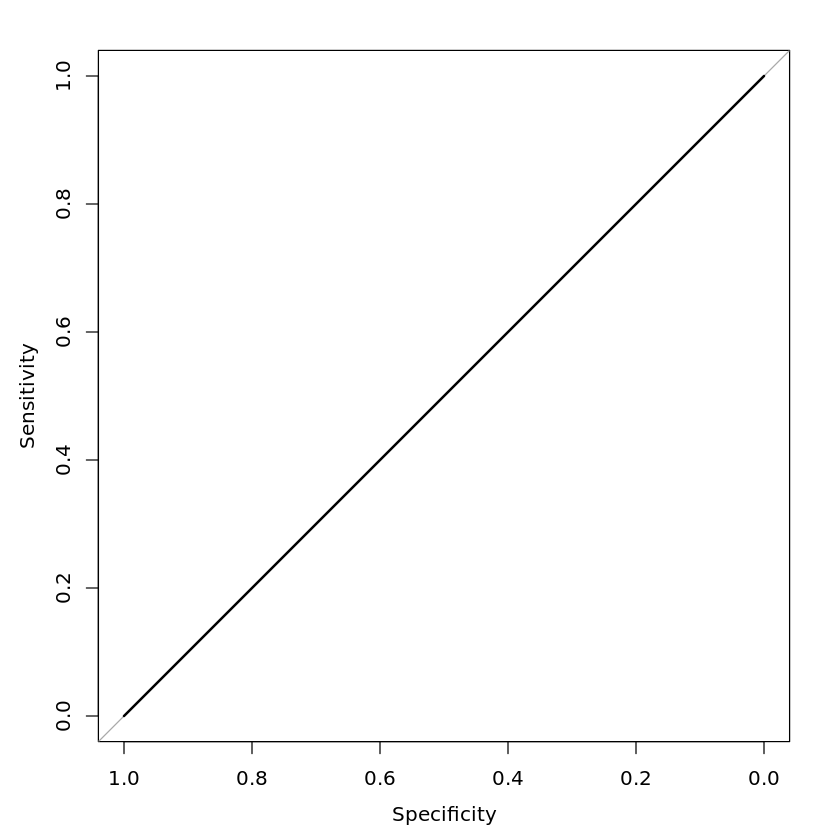

In [30]:
rocs <- roc(observed ~ predicted...2 + 
                    predicted...3 + 
                    predicted...4 + 
                    predicted...5 + 
                    predicted...6 +
                    predicted...7 +
                    predicted...8 + 
                    predicted...9 + 
                    predicted...10 + 
                    predicted...11, data = results)
ggroc(rocs)

In [31]:
roc1 <- roc(results$observed, results$predicted...2)
roc2 <- roc(results$observed, results$predicted...3)
roc3 <- roc(results$observed, results$predicted...4)
roc4 <- roc(results$observed, results$predicted...5)
roc5 <- roc(results$observed, results$predicted...6)
roc6 <- roc(results$observed, results$predicted...7)
roc7 <- roc(results$observed, results$predicted...8)
roc8 <- roc(results$observed, results$predicted...9)
roc9 <- roc(results$observed, results$predicted...10)
roc10 <- roc(results$observed, results$predicted...11)

Area under the curve: 0.5

In [ ]:
paste("Mean AUC over 10 repetitions of 10-fold CV: ", mean(c(auc(roc1), auc(roc2), auc(roc3), auc(roc4), auc(roc5), auc(roc6), auc(roc7), auc(roc8), auc(roc9), auc(roc10))), sep = "")

In [ ]:
results_01 <- results %>% mutate(predicted...2_01 = ifelse(predicted...2 > 0.5, 1, 0), 
                                 predicted...3_01 = ifelse(predicted...3 > 0.5, 1, 0), 
                                 predicted...4_01 = ifelse(predicted...4 > 0.5, 1, 0),
                                 predicted...5_01 = ifelse(predicted...5 > 0.5, 1, 0),
                                 predicted...6_01 = ifelse(predicted...6 > 0.5, 1, 0),
                                 predicted...7_01 = ifelse(predicted...7 > 0.5, 1, 0),
                                 predicted...8_01 = ifelse(predicted...8 > 0.5, 1, 0),
                                 predicted...9_01 = ifelse(predicted...9 > 0.5, 1, 0),
                                 predicted...10_01 = ifelse(predicted...10 > 0.5, 1, 0),
                                 predicted...11_01 = ifelse(predicted...11 > 0.5, 1, 0))

In [ ]:
error_rates <- c(mean(results_01$observed != results_01$predicted...2_01),
               mean(results_01$observed != results_01$predicted...3_01), 
               mean(results_01$observed != results_01$predicted...4_01),
               mean(results_01$observed != results_01$predicted...5_01),
               mean(results_01$observed != results_01$predicted...6_01),
               mean(results_01$observed != results_01$predicted...7_01),
               mean(results_01$observed != results_01$predicted...8_01),
               mean(results_01$observed != results_01$predicted...9_01), 
               mean(results_01$observed != results_01$predicted...10_01), 
               mean(results_01$observed != results_01$predicted...11_01))

error_rates

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")

In [ ]:
accuracies <- c(mean(results_01$observed == results_01$predicted...2_01),
               mean(results_01$observed == results_01$predicted...3_01), 
               mean(results_01$observed == results_01$predicted...4_01),
               mean(results_01$observed == results_01$predicted...5_01),
               mean(results_01$observed == results_01$predicted...6_01),
               mean(results_01$observed == results_01$predicted...7_01),
               mean(results_01$observed == results_01$predicted...8_01),
               mean(results_01$observed == results_01$predicted...9_01), 
               mean(results_01$observed == results_01$predicted...10_01), 
               mean(results_01$observed == results_01$predicted...11_01))

accuracies
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")